In [37]:
# %%
# ==============================================================
# 1. Imports & notebook settings
# ==============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

%matplotlib inline
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 0,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "font.family": "Computer Modern",
    "text.usetex": True,
})

# ------------------------------------------------------------------
# USER SETTINGS (change only these two lines)
# ------------------------------------------------------------------
FITS_NAME = "tsz_2048.fits"
BASE_DIR  = os.path.expanduser("~/Desktop/Project2/Plots/WebSky_Maps")
FITS_FILE = os.path.join(BASE_DIR, FITS_NAME)

OUT_DIR = os.path.join(BASE_DIR, "output_Websky_tSZ")
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Output will be saved to: {OUT_DIR}")

Output will be saved to: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ


In [14]:
# %%
# ==============================================================
# 2. Diagnose FITS structure
# ==============================================================

def diagnose_fits_structure(fname):
    print("\n" + "="*70)
    print(f"DIAGNOSING FITS FILE: {os.path.basename(fname)}")
    print("="*70)
    
    with fits.open(fname) as hdul:
        print(f"\nNumber of HDUs: {len(hdul)}")
        hdul.info()
        
        for i, hdu in enumerate(hdul):
            print(f"\n--- HDU {i}: {hdu.name} ---")
            print(f"Type: {type(hdu)}")
            
            if hasattr(hdu, 'header'):
                print("\nKey header keywords:")
                for key in ['NSIDE', 'ORDERING', 'COORDSYS', 'PIXTYPE',
                           'TTYPE1', 'TUNIT1', 'TFIELDS', 'EXTNAME']:
                    if key in hdu.header:
                        print(f"  {key}: {hdu.header[key]}")
            
            if hasattr(hdu, 'data') and hdu.data is not None:
                if hasattr(hdu.data, 'columns'):
                    print(f"\nColumn names: {hdu.data.columns.names}")
                    for col in hdu.data.columns:
                        print(f"  - {col.name} ({col.format})")
                elif isinstance(hdu.data, np.ndarray):
                    print(f"\nData shape: {hdu.data.shape}")
                    print(f"Data dtype: {hdu.data.dtype}")

if not os.path.isfile(FITS_FILE):
    raise FileNotFoundError(f"Cannot find {FITS_FILE}")

diagnose_fits_structure(FITS_FILE)


DIAGNOSING FITS FILE: tsz_2048.fits

Number of HDUs: 2
Filename: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/tsz_2048.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  MAP           1 BinTableHDU     17   50331648R x 1C   [1D]   

--- HDU 0: PRIMARY ---
Type: <class 'astropy.io.fits.hdu.image.PrimaryHDU'>

Key header keywords:

--- HDU 1: MAP ---
Type: <class 'astropy.io.fits.hdu.table.BinTableHDU'>

Key header keywords:
  NSIDE: 2048
  ORDERING: RING
  PIXTYPE: HEALPIX
  TTYPE1: PIXELS
  TFIELDS: 1
  EXTNAME: MAP

Column names: ['PIXELS']
  - PIXELS (1D)


In [15]:
# %%
# ==============================================================
# 3. Load the tSZ map
# ==============================================================

def load_fits_data(fname):
    print("\n" + "="*70)
    print("LOADING DATA")
    print("="*70)
    
    with fits.open(fname) as hdul:
        # 1. Binary table (most common for HEALPix)
        if len(hdul) > 1 and hasattr(hdul[1].data, 'columns'):
            print("\nDetected: Binary table extension")
            col_names = hdul[1].data.columns.names
            print(f"Available columns: {col_names}")
            
            possible = ['TEMPERATURE', 'I_STOKES', 'SIGNAL', 'Y', 'COMPTONY']
            for name in possible:
                if name in col_names:
                    print(f"Found column: {name}")
                    return hdul[1].data[name], hdul[1].header, name
            
            first = col_names[0]
            print(f"Using first column: {first}")
            return hdul[1].data[first], hdul[1].header, first
        
        # 2. Primary image
        elif len(hdul) > 0 and isinstance(hdul[0].data, np.ndarray):
            print("\nDetected: Primary image array")
            return hdul[0].data, hdul[0].header, "IMAGE"
        
        # 3. Image in extension 1
        elif len(hdul) > 1 and isinstance(hdul[1].data, np.ndarray):
            print("\nDetected: Image in extension 1")
            return hdul[1].data, hdul[1].header, "IMAGE"
        
        else:
            raise ValueError("Could not determine FITS file structure")

data, hdr, column_name = load_fits_data(FITS_FILE)
print(f"\nLoaded column/field: {column_name}")


LOADING DATA

Detected: Binary table extension
Available columns: ['PIXELS']
Using first column: PIXELS

Loaded column/field: PIXELS


In [16]:
# %%
# ==============================================================
# 4. Basic map analysis
# ==============================================================

def analyze_map(map_data, column_name):
    print("\n" + "="*70)
    print("MAP ANALYSIS")
    print("="*70)
    
    print(f"\nColumn/Field: {column_name}")
    print(f"NPIX: {len(map_data)}")
    print(f"NSIDE: {hp.npix2nside(len(map_data))}")
    
    stats = {
        'min': map_data.min(),
        'max': map_data.max(),
        'mean': map_data.mean(),
        'std': map_data.std(),
        'median': np.median(map_data)
    }
    
    print("\nStatistics:")
    for k, v in stats.items():
        print(f"  {k:8s}: {v:.6e}")
    
    if abs(stats['max']) < 1e-3:
        units = "Compton-y"
        is_comptony = True
        print("\n*** Likely Compton-y parameter (dimensionless, ~1e-5 to 1e-6)")
    else:
        units = "µK"
        is_comptony = False
        print("\n*** Likely temperature (µK)")
    
    return stats, units, is_comptony

stats, units, is_comptony = analyze_map(data, column_name)
nside = hp.npix2nside(len(data))
print(f"\nResolution ≈ {hp.nside2resol(nside, arcmin=True):.1f} arcmin")


MAP ANALYSIS

Column/Field: PIXELS
NPIX: 50331648
NSIDE: 2048

Statistics:
  min     : 4.691720e-08
  max     : 2.166952e-04
  mean    : 1.237760e-06
  std     : 1.543460e-06
  median  : 8.838788e-07

*** Likely Compton-y parameter (dimensionless, ~1e-5 to 1e-6)

Resolution ≈ 1.7 arcmin


<Figure size 1600x800 with 0 Axes>

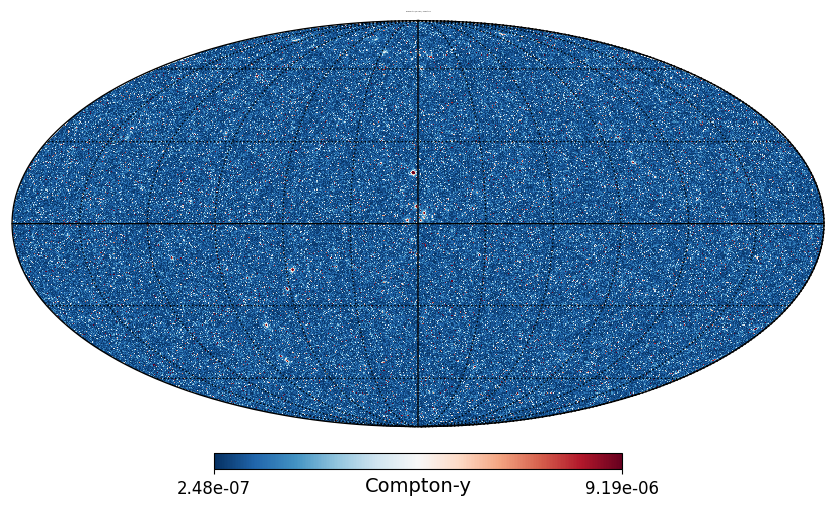

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/websky_tsz_mollweide.pdf


In [23]:
# %%
# ==============================================================
# 5. Mollweide full-sky map (interactive – edit fonts here)
# ==============================================================

vmin, vmax = np.percentile(data, [0.5, 99.5])

plt.figure(figsize=(16, 8))
hp.mollview(
    data,
    title=f'WebSky tSZ (Full Sky) – {units}',
    unit=units,
    cmap='RdBu_r',
    min=vmin, max=vmax,
    format='%.2e' if abs(vmax) < 0.01 else '%.1f'
)
hp.graticule()

# ----- tweak matplotlib objects directly -----
ax = plt.gca()
ax.title.set_fontsize(0)          # change title size
ax.set_xlabel('Galactic longitude', fontsize=14)
ax.set_ylabel('Galactic latitude', fontsize=14)

moll_path = os.path.join(OUT_DIR, "websky_tsz_mollweide.pdf")
plt.savefig(moll_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {moll_path}")


Generating pixel-value histogram...


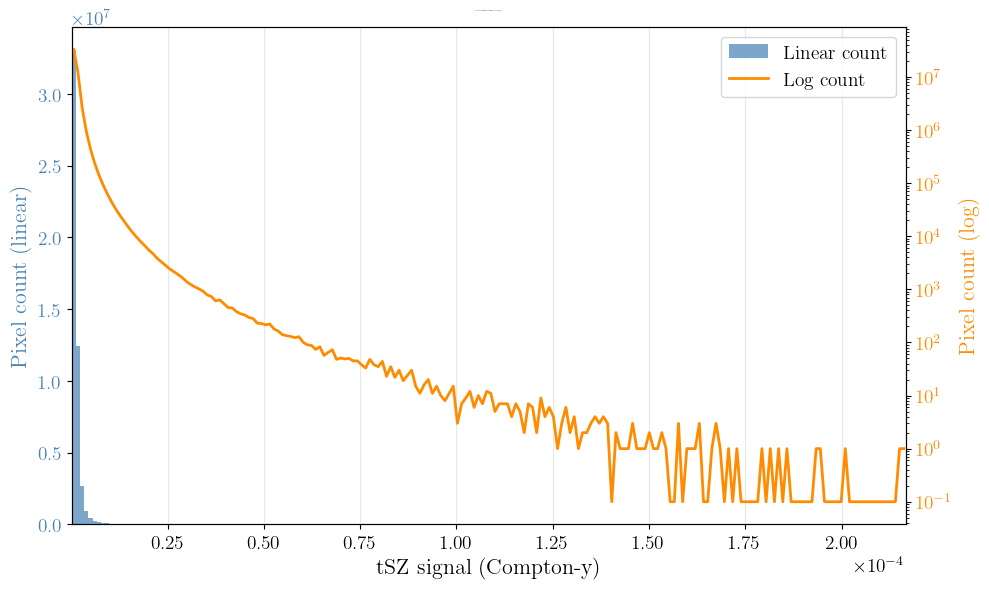

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/websky_tsz_histogram.png
Saved histogram data: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/websky_tsz_histogram_data.txt


In [39]:
# %%
# ==============================================================
# 5.5 Histogram of pixel values (insert before power spectrum)
# ==============================================================

print("\nGenerating pixel-value histogram...")

# Flatten the map and mask extreme outliers for better binning
values = data.flatten()
# Remove NaNs if any (shouldn't be, but safe)
values = values[np.isfinite(values)]

# Use 200 bins, but let numpy choose optimal width
n_bins = 200
counts, bin_edges = np.histogram(values, bins=n_bins, density=False)

# For log-y scale we need to avoid zero counts – add a tiny offset
counts_log = counts.astype(float)
counts_log[counts_log == 0] = np.min(counts_log[counts_log > 0]) * 0.1

# ----- Plot -----
fig, ax = plt.subplots(figsize=(10, 6))

# Linear y-scale on left, log on right (twin axis)
ax_hist = ax
ax_log  = ax.twinx()

# Linear histogram (filled)
ax_hist.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), 
            color='steelblue', alpha=0.7, label='Linear count', align='edge')
ax_hist.set_yscale('linear')
ax_hist.set_ylabel('Pixel count (linear)', color='steelblue', fontsize=16)
ax_hist.tick_params(axis='y', labelcolor='steelblue')

# Log histogram (line)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax_log.plot(bin_centers, counts_log, color='darkorange', linewidth=2, label='Log count')
ax_log.set_yscale('log')
ax_log.set_ylabel('Pixel count (log)', color='darkorange', fontsize=16)
ax_log.tick_params(axis='y', labelcolor='darkorange')

# ------------------------------------------------------------------
# Compact scientific notation on the x-axis
# ------------------------------------------------------------------
ax_hist.set_xlabel(f'tSZ signal ({units})', fontsize=14)

# Let Matplotlib choose tick locations, then format them
ax_hist.xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
ax_hist.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useOffset=False)

# Optional: force a few nice tick positions (uncomment if you want)
# from matplotlib.ticker import MultipleLocator
# ax_hist.xaxis.set_major_locator(MultipleLocator(5e-5))

# X-axis
ax.set_xlabel(f'tSZ signal ({units})', fontsize=16)
ax.set_xlim(bin_edges[0], bin_edges[-1])

# Title & grid
ax.set_title('Distribution of tSZ Pixel Values', fontsize=0, pad=12)
ax.grid(True, which='major', alpha=0.3, axis='x')

# Combine legends
lines1, labels1 = ax_hist.get_legend_handles_labels()
lines2, labels2 = ax_log.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)

plt.tight_layout()

hist_path = os.path.join(OUT_DIR, "websky_tsz_histogram.png")
plt.savefig(hist_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {hist_path}")

# Optional: save histogram data
hist_data_path = os.path.join(OUT_DIR, "websky_tsz_histogram_data.txt")
np.savetxt(hist_data_path, np.column_stack([bin_centers, counts]),
           header='bin_center  pixel_count', fmt='%.6e')
print(f"Saved histogram data: {hist_data_path}")


Computing (or loading cached) power spectrum...
  -> Loading cached C_ℓ from /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/cache/powerspectrum_cl.pkl
  -> Cached ℓ_max = 6143


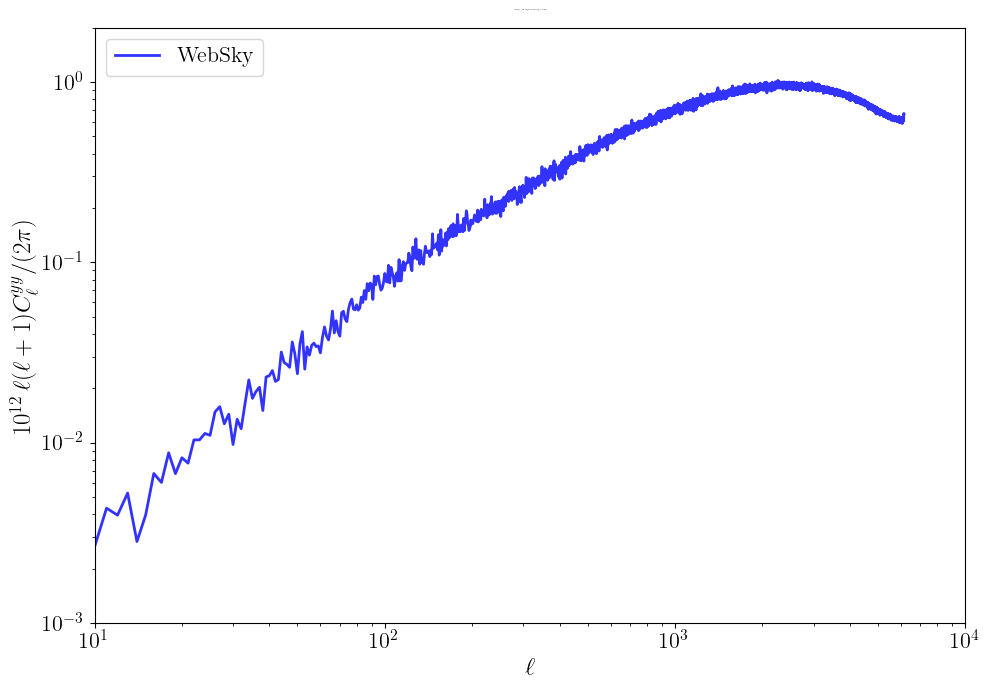

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/websky_tsz_powerspectrum.pdf
Saved spectrum data: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_Websky_tSZ/websky_tsz_powerspectrum_data.txt


In [41]:
# %%
# ==============================================================
# 6. Angular power spectrum (with caching + toggle)
# ==============================================================

import pickle
from pathlib import Path

# --- Cache setup ---
cache_dir = Path(OUT_DIR) / "cache"
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / "powerspectrum_cl.pkl"

# --- TOGGLE: Set to True to force recomputation ---
force_recalculate = False

print("\nComputing (or loading cached) power spectrum...")

# Compute or load based on toggle and cache existence
if force_recalculate or not cache_file.exists():
    print(f"  -> Computing C_ℓ (lmax ≤ 10000)...")
    lmax = min(3*nside-1, 10000)
    cl = hp.anafast(data, lmax=lmax)
    ell = np.arange(len(cl))
    
    # Save to cache
    print(f"  -> Saving C_ℓ to cache: {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump(cl, f)
else:
    print(f"  -> Loading cached C_ℓ from {cache_file}")
    with open(cache_file, 'rb') as f:
        cl = pickle.load(f)
    ell = np.arange(len(cl))
    print(f"  -> Cached ℓ_max = {len(cl)-1}")

# Compute D_ℓ
Dl = ell * (ell + 1) * cl / (2 * np.pi)

# ----- Plot -----
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(ell[2:], Dl[2:]*1e12, 'b-', linewidth=2, label='WebSky', alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 10000)
ax.set_ylim(1e-3, 2)

ax.set_xlabel(r'$\ell$', fontsize=18)
ax.set_ylabel(r'$10^{12} \, \ell(\ell+1) C_\ell^{yy} / (2\pi)$', fontsize=18)
ax.set_title('WebSky tSZ Angular Power Spectrum', fontsize=0, pad=12)

#ax.grid(True, which='both', alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(fontsize=16, loc='upper left')
ax.tick_params(labelsize=16)

plt.tight_layout()
ps_path = os.path.join(OUT_DIR, "websky_tsz_powerspectrum.pdf")
plt.savefig(ps_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {ps_path}")

# Save numeric data
ps_data_path = os.path.join(OUT_DIR, "websky_tsz_powerspectrum_data.txt")
np.savetxt(ps_data_path, np.column_stack([ell, cl, Dl]),
           header='ell  C_ell  D_ell=ell(ell+1)C_ell/(2pi)', fmt='%.6e')
print(f"Saved spectrum data: {ps_data_path}")